# Entrega 4 - Redes Neuronales

### Grupo 9:
     - J. Gu       C.I 5.509.557-9
     - M. Nuñez    C.I 5.225.262-3
     - L. Pereira  C.I 5.268.309-4



## 1. Objetivo

El objetivo de esta tarea es implementar y evaluar distintos modelos basados en redes neuronales y regresión logística, compararlos entre sí y con los modelos realizados en laboratorios anteriores para sacar conclusiones sobre su desempeño. 

El éxito del aprendizaje se mide a través de los valores de accuracy, precisión, recall y f1. Analizaremos los valores de cada uno de los modelos generados y compararemos cual se desempeño mejor.


## 2. Diseño y experimentación

En esta sección, dado que el diseño de los modelos 1 a 4 que había que implementar venía dado por la letra, para dichos modelos solamente aclararemos las consideraciones que tuvimos, si es que fuera necesario, y los análisis de los resultados. Con respecto al modelo 5 y las 3 alternativas planteadas sí aclararemos los detalles del diseño elegido.

Para la implementación de todos los modelos nos basamos fuertemente en el teórico dado en el curso y en la documentación de pytorch. En específico a la documentación brindada en este link: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html.

Aclaraciones:
- Puede que los resultados que se muestran en este informe varien al correr el notebook varias veces. Esto se debe a que las redes neuronales utilizan un parámetro azaroso, por lo que los pesos y las configuraciones varían en cada corrida. Los resultados presentados son con respecto al output actual del informe. Si se corre nuevamente, si bien los resultados generales de los modelos son similares, los valores específicos de estos pueden variar. Si se corre archivos .py de cada uno de los modelos, estos tienen la misma semilla configurada, por lo que en ese caso los resultados si serán los mismos en cada corrida.
- Se tuvo que definir varias veces en el informe las mismas funciones (ej: train_loop, test_loop) ya que entre cada modelo varían levemente sus implementaciones y no se pudo generalizar. Su objetivo y comportamiento es similar en cada uno de los modelos.


In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [178]:
DATASET_FILE = 'lab4_dataset.csv'
dataset = pd.read_csv(DATASET_FILE, sep=",")
dataset = dataset.drop(columns=['time'])

print("Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...")
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_full, test = train_test_split(dataset, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento completo en conjunto de entrenamiento (90%) y validación (10%)
train, validation = train_test_split(train_full, test_size=0.1, random_state=42)

# Separar características (X) y etiquetas (y) para el conjunto de entrenamiento y validación
X_train = train.drop(columns=['cid'])  
y_train = train['cid']

X_val = validation.drop(columns=['cid'])
y_val = validation['cid']


Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...


### Modelo 1

In [179]:
print("Entrenando modelo de regresión logística...")

# Crear el modelo de regresión logística
model1 = LogisticRegression(max_iter=3000)

# Entrenar el modelo con el conjunto de entrenamiento
model1.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de validación
y_pred = model1.predict(X_val)

# Calcular la accuracy en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)

print(f'Accuracy del modelo de regresión logística: {accuracy:.4f}')

Entrenando modelo de regresión logística...
Accuracy del modelo de regresión logística: 0.8023


c:\Users\lpereira\Documents\GitHub\AA-2024\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La regresión logística es un modelo lineal que se adapta bien a problemas de clasificación binaria. En este tipo de conjuntos de datos, el modelo estima la probabilidad de que una instancia pertenezca a una clase determinada, utilizando una combinación lineal de las características. En este caso, la accuracy alcanzada por el modelo es de 0.7733, lo cual es un buen indicador de que el modelo está logrando clasificar correctamente el 77.33% de las instancias.

La precisión en términos generales, indica que el modelo tiene un buen desempeño clasificando correctamente las instancias del dataset. Sin embargo, es importante tener en cuenta que la accuracy por sí sola puede ser engañosa en casos de desbalance de clases. En conjuntos de datos con muchas más instancias de una clase (como es el caso aquí con más instancias negativas), el modelo puede obtener una alta accuracy simplemente por predecir siempre la clase mayoritaria, sin necesariamente identificar bien las instancias de la clase minoritaria.

### Modelo 2

In [180]:
# Definir el modelo con una sola neurona lineal y dos salidas (para 2 clases)
class SimpleNN(nn.Module):
    def __init__(self, features):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(features, 2)  #features es el número de características

    def forward(self, x):
        return self.linear(x)

In [181]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct


In [182]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [183]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleNN(X_train_tensor.shape[1])

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.6898, Train Accuracy: 0.5634, Val Loss: 0.6880, Val Accuracy: 0.5581
Epoch [20/100], Loss: 0.5969, Train Accuracy: 0.7070, Val Loss: 0.6170, Val Accuracy: 0.6802
Epoch [30/100], Loss: 0.5575, Train Accuracy: 0.7485, Val Loss: 0.5776, Val Accuracy: 0.7209
Epoch [40/100], Loss: 0.5316, Train Accuracy: 0.7700, Val Loss: 0.5534, Val Accuracy: 0.7384
Epoch [50/100], Loss: 0.5192, Train Accuracy: 0.7817, Val Loss: 0.5373, Val Accuracy: 0.7558
Epoch [60/100], Loss: 0.4993, Train Accuracy: 0.7882, Val Loss: 0.5261, Val Accuracy: 0.7558
Epoch [70/100], Loss: 0.4899, Train Accuracy: 0.7914, Val Loss: 0.5183, Val Accuracy: 0.7616
Epoch [80/100], Loss: 0.4834, Train Accuracy: 0.7901, Val Loss: 0.5117, Val Accuracy: 0.7558
Epoch [90/100], Loss: 0.4797, Train Accuracy: 0.7888, Val Loss: 0.5067, Val Accuracy: 0.7616
Epoch [100/100], Loss: 0.4745, Train Accuracy: 0.7901, Val Loss: 0.5034, Val Accuracy: 0.7674


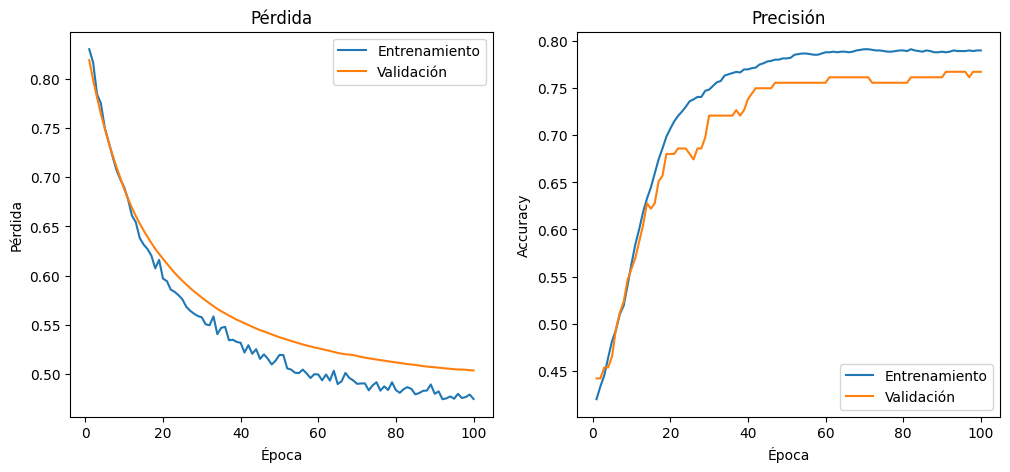

In [184]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

En este experimento, se entrenó una red neuronal con una sola capa lineal, utilizando la función de pérdida de entropía cruzada. Los resultados mostraron una convergencia estable tanto en la pérdida como en la accuracy, tanto para el conjunto de entrenamiento como para el conjunto de validación, a lo largo de las 100 épocas.

##### Observaciones:

- Pérdida: La pérdida disminuye consistentemente en ambos conjuntos, indicando que el modelo está aprendiendo de manera efectiva. Sin embargo, se observa que la curva de validación comienza a disminuir su pendiente después de aproximadamente 40 épocas, lo que sugiere que el modelo alcanza su punto de convergencia relativamente temprano.
- Accuracy: La accuracy en el conjunto de validación alcanza una meceta entre 0.75 y 0.76 lrededor de la época 50, lo que se corresponde con lo que se ve en la gráfica de pérdida, donde las curvas no son tan pronunciadas tras esa cantidad de épocas. Esto indica que el modelo no sigue mejorando significativamente en la segunda mitad del entrenamiento.

### Modelo 3

In [185]:
class SimpleSigmoidNN(nn.Module):
    def __init__(self, features):
        super(SimpleSigmoidNN, self).__init__()
        self.linear = nn.Linear(features, 1)  # Una neurona, una salida
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Activación sigmoide

In [186]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [187]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [188]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleSigmoidNN(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.7037, Train Accuracy: 0.5367, Val Loss: 0.7103, Val Accuracy: 0.5581
Epoch [20/100], Loss: 0.6493, Train Accuracy: 0.6322, Val Loss: 0.6632, Val Accuracy: 0.6686
Epoch [30/100], Loss: 0.6035, Train Accuracy: 0.6946, Val Loss: 0.6287, Val Accuracy: 0.6977
Epoch [40/100], Loss: 0.5802, Train Accuracy: 0.7212, Val Loss: 0.6027, Val Accuracy: 0.6977
Epoch [50/100], Loss: 0.5589, Train Accuracy: 0.7505, Val Loss: 0.5831, Val Accuracy: 0.6919
Epoch [60/100], Loss: 0.5446, Train Accuracy: 0.7615, Val Loss: 0.5675, Val Accuracy: 0.7209
Epoch [70/100], Loss: 0.5311, Train Accuracy: 0.7765, Val Loss: 0.5552, Val Accuracy: 0.7267
Epoch [80/100], Loss: 0.5205, Train Accuracy: 0.7836, Val Loss: 0.5450, Val Accuracy: 0.7209
Epoch [90/100], Loss: 0.5141, Train Accuracy: 0.7849, Val Loss: 0.5372, Val Accuracy: 0.7326
Epoch [100/100], Loss: 0.5037, Train Accuracy: 0.7901, Val Loss: 0.5301, Val Accuracy: 0.7500


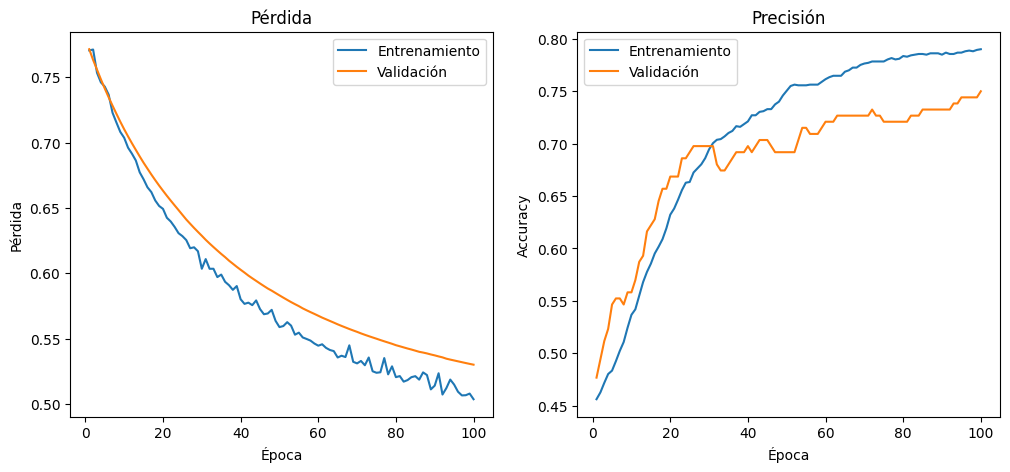

In [189]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

En este experimento, se entrenó una red neuronal compuesta por una sola neurona, utilizando la función de pérdida de entropía cruzada binaria (BCEntropyLoss). La red tiene una única salida con función de activación sigmoide, para estimar la probabilidad de pertenencia a cada clase objetivo. Se entrenó el modelo durante 100 épocas, y se graficaron tanto la pérdida como la precisión (accuracy) en los conjuntos de entrenamiento y validación.

#### Observaciones:

- **Pérdida**: La pérdida muestra una disminución constante en ambos conjuntos (entrenamiento y validación), lo que indica un aprendizaje estable del modelo. La curva de pérdida en el conjunto de validación parece disminuir más suavemente a medida que pasa el tiempo, teniendo una disminución más pronunciada en las primeras épocas y luego estabilizandose.

- **Accuracy**: La precisión (accuracy) también incrementa rápidamente en ambas curvas, alcanzando un valor cercano al 0.75 en el conjunto de validación. Vemos como sobre la época 80 el conjunto de validación se estabiliza, mostrando poco aumento de la accuracy luego de ese momento, mientras que en el conjunto de entrenamiento continua aumentando aunque mucho menos pronunciado que en las primeras épocas.
En general, los resultados sugieren una buena convergencia y estabilidad en el entrenamiento de la red neuronal. Sin embargo, se ve como sobre el final el modelo deja de aprender tanto y se estabiliza la accuracy en el conjunto de validación, lo que podría indicar que si se siguiera entrenando durante más épocas, esto pudiera generar un sobreajuste, haciendo que la accuracy del conjunto de entrenamiento continuara aumentando y que disminuyera la de validación.


### Modelo 4

In [190]:
class SigmoidNNWithHiddenLayer(nn.Module):
    def __init__(self, features):
        super(SigmoidNNWithHiddenLayer, self).__init__()
        self.hidden = nn.Linear(features, 16)   # Capa oculta con 16 unidades
        self.output = nn.Linear(16, 2)          # Capa de salida con 2 neuronas (para las dos clases)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.softmax(self.output(x), dim=1) # Softmax para obtener probabilidades
        return x

In [191]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)  # La salida ya tiene forma (batch_size, 2)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Obtener la clase predicha (índice de la mayor probabilidad)
        pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [192]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)  # La salida ya tiene forma (batch_size, 2)
            test_loss += loss_fn(pred, y).item()

            # Obtener la clase predicha (índice de la mayor probabilidad)
            pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [193]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
# Crear la red neuronal
model = SigmoidNNWithHiddenLayer(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5541, Train Accuracy: 0.7570, Val Loss: 0.5714, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5523, Train Accuracy: 0.7570, Val Loss: 0.5700, Val Accuracy: 0.7326
Epoch [30/100], Loss: 0.5573, Train Accuracy: 0.7570, Val Loss: 0.5692, Val Accuracy: 0.7326
Epoch [40/100], Loss: 0.5505, Train Accuracy: 0.7570, Val Loss: 0.5681, Val Accuracy: 0.7326
Epoch [50/100], Loss: 0.5491, Train Accuracy: 0.7570, Val Loss: 0.5662, Val Accuracy: 0.7326
Epoch [60/100], Loss: 0.5464, Train Accuracy: 0.7570, Val Loss: 0.5620, Val Accuracy: 0.7326
Epoch [70/100], Loss: 0.5402, Train Accuracy: 0.7570, Val Loss: 0.5549, Val Accuracy: 0.7326
Epoch [80/100], Loss: 0.5319, Train Accuracy: 0.7641, Val Loss: 0.5474, Val Accuracy: 0.7500
Epoch [90/100], Loss: 0.5247, Train Accuracy: 0.7745, Val Loss: 0.5412, Val Accuracy: 0.7733
Epoch [100/100], Loss: 0.5204, Train Accuracy: 0.7810, Val Loss: 0.5368, Val Accuracy: 0.7733


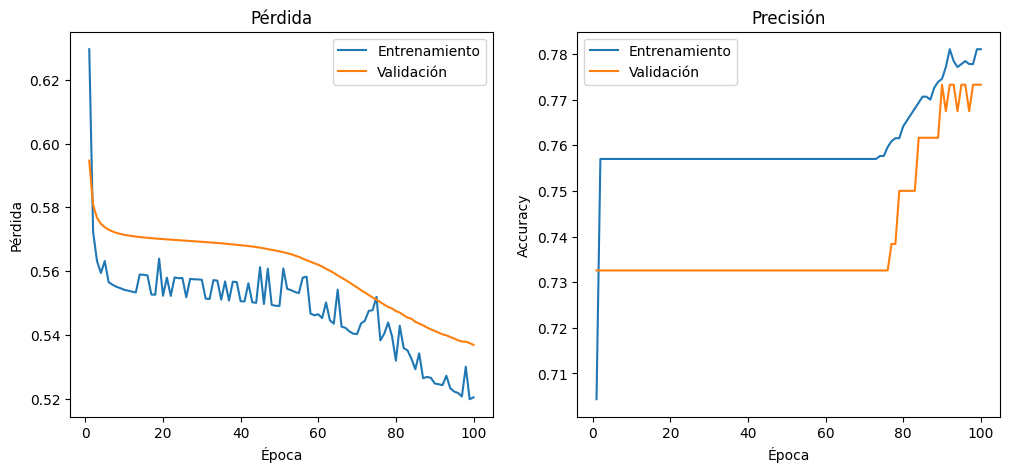

In [194]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

En este experimento, se entrenó una red neuronal feedforward con una capa oculta de 16 neuronas, utilizando la función de activación sigmoide en la salida para devolver la probabilidad de cada clase objetivo. La función de pérdida utilizada fue la entropía cruzada binaria (BCEWithLogitsLoss), apropiada para problemas de clasificación binaria. El modelo se entrenó durante 100 épocas, y se graficaron tanto la pérdida como la precisión (accuracy) en los conjuntos de entrenamiento y validación.

#### Observaciones:

- **Pérdida**: La curva de pérdida muestra una disminución constante en ambos conjuntos (entrenamiento y validación), aunque en el caso del entrenamiento oscila y en el caso de la validación disminuye con una curva pronunciada y luego se estabiliza sobre el final. Esto sugiere que el modelo está logrando una buena convergencia sin signos evidentes de sobreajuste, al ambos conjuntos disminuir su pérdida al pasar las épocas.

- **Accuracy**: La precisión (accuracy) en ambos conjuntos comienza manteniendose estable en un valor de 0.7570 (entrenamiento) y un valor de 0.7326 (validación). Al llegar a aproximadamente la época 70 ambos conjuntos comienzan a aumentar su accuracy. En el caso del entrenamiento aumenta de una forma más constante, con algunos altibajos, y en el caso del conjunto de validación tiene ciertas oscilaciones y no crece tan constante como el entrenamiento. Esto podría ser un indicador de sobreajuste, viendo como ambas líneas están muy separadas y mientras la de entrenamiento sigue aumentando, la de validación no tanto.

## Modelo 5.A

La primer arquitectura que planteamos para intentar mejorar los resultados previamente obtenidos esta compuesta por:

- Una capa de entrada lineal, que recibe el número de atributos a utilizar como de entrada y las transforma en 16 neuronas.

- Una función de activación LeakyReLU que se aplica después de la capa de entrada para añadir no linealidad y permitir que la red aprenda patrones más complejos.

- Un Dropout con probabilidad 0.4 después de la capa de entrada, que desactiva el 40% de las neuronas en cada paso para reducir el riesgo de sobreajuste.

- Una capa oculta lineal que recibe las 16 neuronas de la capa de entrada y las reduce a 8 neuronas para continuar el proceso de aprendizaje.

- Otra función de activación LeakyReLU que se aplica después de la capa oculta para introducir una segunda no linealidad en el modelo.

- Un segundo Dropout de probabilidad 0.4, que vuelve a desactivar el 40% de las neuronas en la capa oculta para mejorar la generalización.

- Una capa de salida lineal, que recibe las 8 neuronas de la capa oculta y produce una única salida que representa la probabilidad de una clase en un problema de clasificación binaria.

Esta arquitectura permite que la red clasifique las entradas en una de dos clases posibles (binaria), aplicando la función de pérdida BCEWithLogitsLoss, que calcula la pérdida con una activación sigmoide para obtener probabilidades en la salida.
Esta red se utilizó con el optimizador SGD, que se basa en el descenso por gradiente y con un paso de 0.05 de tasa de aprendizaje. Este paso fue definido tras probar con distintos valores y ver que el mejor desempeño se dió en este caso.

In [195]:
class NeuronalNetworkV1(nn.Module):
    def __init__(self, features):
        super(NeuronalNetworkV1, self).__init__()
        self.input_layer = nn.Linear(features, 16)
        self.hidden_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)

        # Añadir más capas ocultas
        self.hidden_layer1 = nn.Linear(16, 8)
        
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.hidden_layer1(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [196]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
        pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [197]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
            pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [198]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = NeuronalNetworkV1(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5173, Train Accuracy: 0.7570, Val Loss: 0.5146, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5227, Train Accuracy: 0.7570, Val Loss: 0.5111, Val Accuracy: 0.7326
Epoch [30/100], Loss: 0.5022, Train Accuracy: 0.7713, Val Loss: 0.4994, Val Accuracy: 0.7616
Epoch [40/100], Loss: 0.4768, Train Accuracy: 0.7687, Val Loss: 0.4941, Val Accuracy: 0.7674
Epoch [50/100], Loss: 0.4804, Train Accuracy: 0.7765, Val Loss: 0.4920, Val Accuracy: 0.7616
Epoch [60/100], Loss: 0.4713, Train Accuracy: 0.7778, Val Loss: 0.4956, Val Accuracy: 0.7674
Epoch [70/100], Loss: 0.4644, Train Accuracy: 0.7778, Val Loss: 0.4974, Val Accuracy: 0.7558
Epoch [80/100], Loss: 0.4715, Train Accuracy: 0.7804, Val Loss: 0.4959, Val Accuracy: 0.7442
Epoch [90/100], Loss: 0.4641, Train Accuracy: 0.7732, Val Loss: 0.5025, Val Accuracy: 0.7500
Epoch [100/100], Loss: 0.4500, Train Accuracy: 0.7940, Val Loss: 0.5081, Val Accuracy: 0.7674


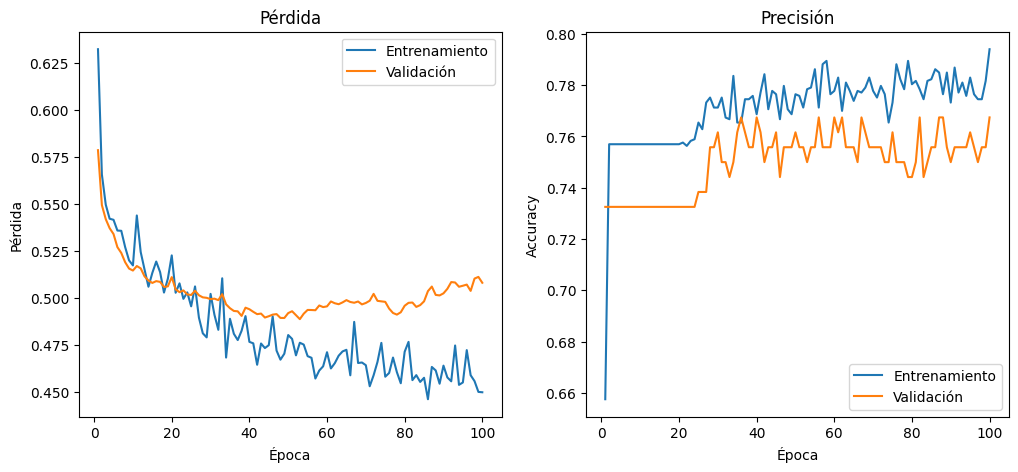

In [199]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Observaciones:

- **Pérdida**: La pérdida disminuye rápidamente durante las primeras épocas en ambos conjuntos, lo que indica que el modelo está aprendiendo de manera efectiva en las etapas iniciales. A medida que avanza el entrenamiento, la pérdida en el conjunto de entrenamiento presenta más fluctuaciones, probablemente debido al efecto de Dropout y a la tasa de aprendizaje relativamente alta. La pérdida en el conjunto de validación tiende a estabilizarse alrededor de 0.5 después de aproximadamente 30 épocas, lo que sugiere que el modelo está logrando una buena generalización, aunque con cierta variabilidad. El hecho de que la pérdida siga disminuyendo en el conjunto de entrenamiento pero no en el de validación puede ser un indicador de sobreajuste.

- **Accuracy**: La precisión (accuracy) en el conjunto de entrenamiento muestra un comportamiento oscilante pero con una tendencia general de mejora, alcanzando un máximo cercano a 0.79. En el conjunto de validación, la precisión también incrementa inicialmente y luego continua oscilando entre 0.75 y 0.78. Estas oscilaciones pueden deberse al uso de Dropout, que introduce aleatoriedad en la activación de neuronas, lo que a su vez afecta la consistencia del desempeño en cada época. 

En general, los resultados sugieren que la arquitectura mejorada logra una mayor capacidad de aprendizaje, pero a costa de mayor inestabilidad en los valores de pérdida y precisión a lo largo del entrenamiento.

## Modelo 5.B

La segunda arquitectura que planteamos para intentar mejorar los resultados previamente obtenidos está compuesta por:

- Capa de entrada: una capa lineal que recibe el número de atributos de entrada y los transforma en 8 neuronas. Esta capa inicial es seguida de una normalización BatchNorm1d para estandarizar la activación de las neuronas en la red y acelerar el proceso de entrenamiento.

- Función de activación: se utiliza la función de activación ReLU, fue elegida en este modelo debido a su simplicidad y rendimiento eficiente en la mayoría de los problemas de clasificación. ReLU es particularmente eficaz cuando se espera que los valores de activación negativos no contribuyan significativamente al aprendizaje, lo que permite que las neuronas se apaguen cuando reciben activaciones negativas. Esto puede acelerar el entrenamiento, ya que reduce el riesgo de que la red se vea afectada por valores pequeños que se propagan a lo largo de las capas.. Esta función se aplica después de la capa de entrada y de las capas ocultas.

- Capa oculta: en lugar de dos capas ocultas, esta arquitectura utiliza solo una capa oculta lineal que reduce las 8 neuronas a 4. Esta capa también está seguida de una normalización BatchNorm1d para mantener las activaciones de la red en una escala adecuada.

- Dropout: se utiliza un Dropout con una probabilidad de 0.4 después de la capa oculta. El Dropout desactiva el 32.5% de las neuronas durante el entrenamiento, lo que ayuda a mejorar la generalización y reduce el riesgo de sobreajuste.

- Capa de salida: una capa lineal que recibe las 4 neuronas de la capa oculta y produce una única salida, representando la probabilidad de la clase en un problema de clasificación binaria.

- Esta arquitectura permite que la red neuronal clasifique las entradas en una de dos clases posibles (problema de clasificación binaria). La función de pérdida utilizada es BCEWithLogitsLoss, que combina la función de pérdida de entropía cruzada con una activación sigmoide interna para obtener probabilidades en la salida.

- El optimizador utilizado es Adam, conocido por su eficiencia en problemas de optimización, con una tasa de aprendizaje de 0.001. Este valor fue elegido tras probar distintas tasas de aprendizaje, observando un mejor rendimiento con esta configuración.

La red fue entrenada utilizando un ciclo de entrenamiento definido por la función train_loop, que maneja el entrenamiento batch por batch. Durante cada batch, se calcula la pérdida y se ajustan los pesos de la red utilizando el optimizador Adam. A diferencia del descenso por gradiente estándar, que utiliza una única tasa de aprendizaje para todos los parámetros, Adam adapta la tasa de aprendizaje de manera individual para cada parámetro, basándose en el promedio móvil de los gradientes y el promedio móvil de los cuadrados de los gradientes anteriores. Esto permite que Adam mantenga un equilibrio entre la eficiencia de convergencia y la estabilidad, siendo especialmente efectivo en problemas con datos ruidosos o características escasas.

In [200]:
class NeuronalNetworkV2(nn.Module):
    def __init__(self, features):
        super(NeuronalNetworkV2, self).__init__()
        # Capa de entrada
        self.input_layer = nn.Linear(features, 8)
        self.hidden_activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(8)
        
        # Capa oculta (una en lugar de dos)
        self.hidden_layer = nn.Linear(8, 4)
        self.batch_norm2 = nn.BatchNorm1d(4)
        
        # Capa de salida
        self.output_layer = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.4)  # 50% de dropout

    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm1(x)
        x = self.hidden_activation(x)
        
        x = self.hidden_layer(x)
        x = self.batch_norm2(x)
        x = self.hidden_activation(x)
        
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [201]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = torch.sigmoid(pred)
        pred_class = (pred > 0.5).type(torch.float)
        correct += (pred_class == y).type(torch.float).sum().item()

    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [202]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()

            pred = torch.sigmoid(pred)
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [203]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

model = NeuronalNetworkV2(X_train_tensor.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.5401, Train Accuracy: 0.7492, Val Loss: 0.5400, Val Accuracy: 0.7500
Epoch [20/100], Loss: 0.5059, Train Accuracy: 0.7596, Val Loss: 0.5247, Val Accuracy: 0.7733
Epoch [30/100], Loss: 0.4920, Train Accuracy: 0.7726, Val Loss: 0.5154, Val Accuracy: 0.7733
Epoch [40/100], Loss: 0.4718, Train Accuracy: 0.7758, Val Loss: 0.5054, Val Accuracy: 0.7674
Epoch [50/100], Loss: 0.4865, Train Accuracy: 0.7713, Val Loss: 0.4846, Val Accuracy: 0.7616
Epoch [60/100], Loss: 0.4644, Train Accuracy: 0.7836, Val Loss: 0.4968, Val Accuracy: 0.7674
Epoch [70/100], Loss: 0.4610, Train Accuracy: 0.7745, Val Loss: 0.4838, Val Accuracy: 0.7733
Epoch [80/100], Loss: 0.4633, Train Accuracy: 0.7726, Val Loss: 0.4926, Val Accuracy: 0.7616
Epoch [90/100], Loss: 0.4703, Train Accuracy: 0.7804, Val Loss: 0.4940, Val Accuracy: 0.7674
Epoch [100/100], Loss: 0.4498, Train Accuracy: 0.7921, Val Loss: 0.4927, Val Accuracy: 0.7849


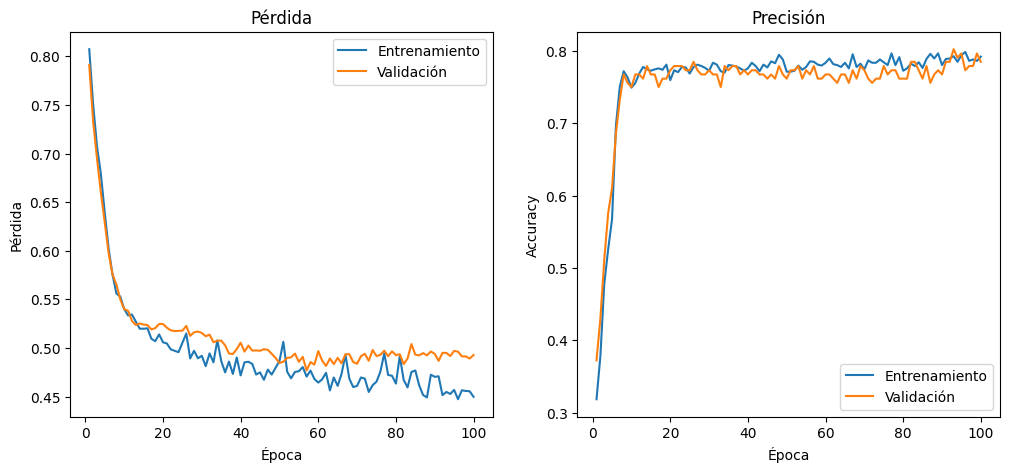

In [204]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Entrenamiento')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##### Observaciones:

- Pérdida:
 A lo largo de las 100 épocas, la pérdida disminuye de manera constante, lo que sugiere que el modelo está aprendiendo y ajustando correctamente sus parámetros. Sin embargo, a partir de la época 60, la pérdida se estabiliza tanto para el conjunto de entrenamiento como para el conjunto de validación, lo que indica que el modelo ha alcanzado su capacidad máxima de aprendizaje. En general, el comportamiento de la pérdida muestra que no hay signos de sobreajuste evidente, ya que ambas curvas de pérdida (entrenamiento y validación) siguen trayectorias similares.

- Accuracy:
 En la época 10, la accuracy en el conjunto de validación alcanzó el 75.00%, y continuó mejorando hasta alcanzar un valor máximo de 78.49% en la época 100. Después de la época 10, la accuracy se mantiene relativamente estable, mejorando levemente al pasar las épocas, mostrando un buen rendimiento general del modelo.
La pequeña diferencia entre la accuracy de entrenamiento y la de validación sugiere que el modelo tiene una buena capacidad de generalización, es decir, es capaz de predecir correctamente en datos no vistos.

- Conclusiones:

    Si bien la accuracy no sigue mejorando después de las primeras 10-20 épocas, la estabilidad del modelo indica que ha aprendido patrones importantes en los datos sin sobreajustar.

    Es posible que ajustando la tasa de aprendizaje o implementando técnicas de regularización adicionales, como una tasa de Dropout más alta o early stopping, se pueda mejorar aún más la performance.

## Modelo 5.C

La arquitectura implementada para el Modelo 5.C consiste en una red neuronal profunda con bloques residuales, diseñada para mejorar los resultados obtenidos y minimizar el riesgo de sobreajuste en el conjunto de datos.

Esta red está compuesta por:

- Una capa de entrada lineal, que recibe el número de atributos del conjunto de datos como entrada y los transforma en 32 neuronas para iniciar el aprendizaje.

- Una función de activación ReLU, que se aplica después de la capa de entrada para introducir no linealidad, permitiendo que la red aprenda relaciones complejas en los datos.

- Dos bloques residuales:
   - Cada bloque residual contiene dos capas lineales de 32 neuronas cada una, con una función de activación ReLU aplicada después de cada capa.
   - Al final de cada bloque residual, se añade una conexión residual. Una conexión residual implica sumar la entrada original del bloque a la salida final del mismo bloque, después de que las dos capas lineales y sus activaciones han sido aplicadas. Esto permite que los gradientes fluyan más fácilmente, ayudando a evitar problemas de desvanecimiento del gradiente y facilitando el aprendizaje en redes más profundas.

- Un Dropout con probabilidad de 0.6 que se aplica después de cada bloque residual para reducir el riesgo de sobreajuste, apagando el 60% de las neuronas aleatoriamente en cada iteración y ayudando a mejorar la generalización del modelo.

- Una capa de salida lineal, que recibe las 32 neuronas de los bloques residuales y produce una única salida que representa la probabilidad de la clase en el problema de clasificación binaria.

Para entrenar esta arquitectura, se utilizó la función de pérdida BCEWithLogitsLoss, que combina la función de activación sigmoide y la entropía cruzada binaria en una sola operación. Esto permite calcular la pérdida de manera estable y eficiente, transformando la salida en una probabilidad para la clasificación.

El modelo se entrenó usando el optimizador SGD, configurado con los siguientes parámetros:
   - Tasa de aprendizaje: 0.05, elegida para lograr un equilibrio entre velocidad y estabilidad en el entrenamiento.
   - Weight Decay: 1e-4, que penaliza los pesos grandes para mejorar la generalización y reducir el riesgo de sobreajuste.



In [205]:
# Definir el bloque residual
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.layer1 = nn.Linear(features, 32)
        self.layer2 = nn.Linear(32, 32)
        # Asegurarnos de que ReLU no se aplique in-place
        self.activation = nn.ReLU(inplace=False)

    def forward(self, x):
        identity = x  # Guardamos la entrada original para la conexión residual
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        out = self.activation(out)
        
        # Añadimos la conexión residual sin modificar in-place
        out = out + identity  # Evitar operación in-place
        return out

In [206]:
# Red Neuronal Profunda con bloques residuales (ajustado a 2 bloques)
class DeepResidualNetwork(nn.Module):
    def __init__(self, input_features):
        super(DeepResidualNetwork, self).__init__()
        self.input_layer = nn.Linear(input_features, 32)
        self.activation = nn.ReLU(inplace=False)
        
        # Reducido a 2 bloques residuales
        self.residual_block1 = ResidualBlock(32)
        self.residual_block2 = ResidualBlock(32)

        # Capa de salida
        self.output_layer = nn.Linear(32, 1)  # Para clasificación binaria
        self.dropout = nn.Dropout(0.6)  # Ajustar el dropout a 0.5

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        
        # Pasar a través de los bloques residuales
        x = self.dropout(self.residual_block1(x))
        x = self.dropout(self.residual_block2(x))

        # Capa de salida
        x = self.output_layer(x)
        return x

In [207]:
# Función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
        pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [208]:
# Función de validación/prueba
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
            pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [209]:
    # Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal con 2 bloques residuales
model = DeepResidualNetwork(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD con L2 regularization)
criterion = nn.BCEWithLogitsLoss()  # Para clasificación binaria
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)  # Reducir la tasa de aprendizaje y añadir L2


Epoch [10/100], Loss: 0.5363, Train Accuracy: 0.7622, Val Loss: 0.5180, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5110, Train Accuracy: 0.7628, Val Loss: 0.5023, Val Accuracy: 0.7326
Epoch [30/100], Loss: 0.4913, Train Accuracy: 0.7706, Val Loss: 0.4892, Val Accuracy: 0.7500
Epoch [40/100], Loss: 0.4978, Train Accuracy: 0.7667, Val Loss: 0.4854, Val Accuracy: 0.7500
Epoch [50/100], Loss: 0.4678, Train Accuracy: 0.7843, Val Loss: 0.4800, Val Accuracy: 0.7558
Epoch [60/100], Loss: 0.4720, Train Accuracy: 0.7823, Val Loss: 0.4812, Val Accuracy: 0.7500
Epoch [70/100], Loss: 0.4569, Train Accuracy: 0.7934, Val Loss: 0.4861, Val Accuracy: 0.7907
Epoch [80/100], Loss: 0.4442, Train Accuracy: 0.7966, Val Loss: 0.4842, Val Accuracy: 0.8081
Epoch [90/100], Loss: 0.4452, Train Accuracy: 0.8025, Val Loss: 0.5033, Val Accuracy: 0.7907
Epoch [100/100], Loss: 0.4352, Train Accuracy: 0.8057, Val Loss: 0.5195, Val Accuracy: 0.8081


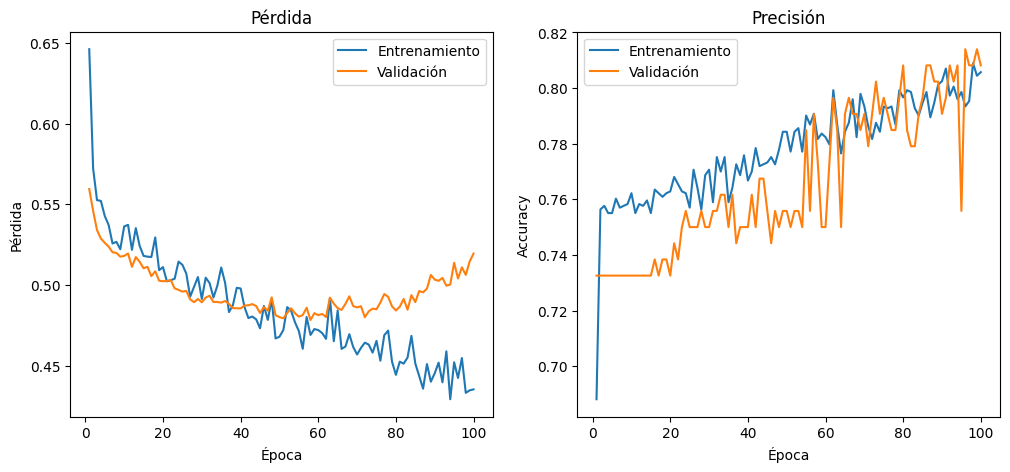

In [210]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Observaciones:

- **Pérdida**: La pérdida en el conjunto de entrenamiento muestra una disminución estable, lo que indica que el modelo está aprendiendo de manera continua. Sin embargo, en el conjunto de validación, la pérdida comienza a aumentar después de algunas épocas, lo cual es indicativo de sobreajuste. Este aumento sugiere que el modelo está capturando detalles específicos del conjunto de entrenamiento que no generalizan bien al conjunto de validación.

- **Accuracy**: La precisión (accuracy) en el conjunto de entrenamiento sigue mejorando a lo largo de las épocas, alcanzando aproximadamente 0.80. En el conjunto de validación, la precisión también mejora inicialmente, pero se estabiliza alrededor de 0.81 y luego fluctúa, lo cual puede deberse al mismo problema de sobreajuste observado en la pérdida.


Aunque el Modelo 5.C demuestra un buen aprendizaje en el conjunto de entrenamiento, su alta complejidad lo hace más susceptible al sobreajuste en un conjunto de datos pequeño como el que estamos utilizando. La estructura de bloques residuales es más adecuada para conjuntos de datos grandes o problemas de mayor complejidad, donde los beneficios de los bloques residuales pueden aprovecharse al máximo. En este caso, la complejidad del modelo parece excesiva y resulta en una disminución de la capacidad de generalización.

## 3. Elección de Modelo 5

Tras construir las 3 distintas arquitecturas para intentar mejorar los resultados obtenidos y analizar sus gráficas de pérdida y accuracy, decidimos tomar como mejor modelo al modelo 5.B.
Esto lo hicimos viendo que el modelo 5.A y 5.C tienen algunos indicadores de sobreajuste en las gráficas de pérdida y sus gráficas de accuracy muestran bastantes oscilaciones en los resultados. En cambio, el modelo 5.B es mucho más estable en ambas gráficas y tanto el conjunto de entrenamiento como el de validación se comportan similar al aumentar las épocas.

## 4. Análisis de resultados

En esta sección, se presentan los resultados obtenidos a partir de diferentes modelos aplicados al problema en estudio. La experimentación se ha dividido en dos fases principales: en primer lugar, la evaluación y comparación de múltiples arquitecturas de redes neuronales diseñadas específicamente para este conjunto de datos, y, en segundo lugar, la comparación entre estos modelos de redes neuronales y otros algoritmos de aprendizaje automático clásicos, como ID3 y Naive Bayes.

Cada modelo fue evaluado en términos de precisión (accuracy), precisión promedio (precision), recall promedio, F1 Score y desviación estándar, permitiendo no solo entender el rendimiento de cada técnica, sino también la estabilidad de sus predicciones a través de diferentes divisiones de entrenamiento y validación.

Las tablas a continuación resumen los resultados obtenidos para cada modelo. Las primeras tablas presentan los resultados de los modelos basados en árboles de decisión y Naive Bayes, mientras que la última tabla detalla el rendimiento de las redes neuronales probadas. A través de estos resultados, se busca identificar la arquitectura que mejor generaliza sobre los datos de prueba y validar si las redes neuronales ofrecen una mejora significativa en el rendimiento en comparación con los métodos clásicos de clasificación.

<table>
  <tr>
    <th>Algoritmo</th>
    <th>Datos utilizados para pruebas</th>
    <th>Acierto promedio (%)</th>
    <th>Desviación estándar</th>
  </tr>
  <tr>
    <td>ID3 (max_range_split = 2)</td>
    <td>Entrenamiento</td>
    <td>98.04</td>
    <td>0.12</td>
  </tr>
  <tr>
    <td>ID3 (max_range_split = 2)</td>
    <td>Evaluación</td>
    <td>83.31</td>
    <td>1.13</td>
  </tr>
  <tr>
    <td>ID3 (max_range_split = 3)</td>
    <td>Entrenamiento</td>
    <td>98.04</td>
    <td>0.12</td>
  </tr>
  <tr>
    <td>ID3 (max_range_split = 3)</td>
    <td>Evaluación</td>
    <td>83.31</td>
    <td>1.13</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1)</td>
    <td>Entrenamiento</td>
    <td>84.22</td>
    <td>0.50</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1)</td>
    <td>Evaluación</td>
    <td>83.54</td>
    <td>0.79</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 10)</td>
    <td>Entrenamiento</td>
    <td>84.24</td>
    <td>0.49</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 10)</td>
    <td>Evaluación</td>
    <td>83.59</td>
    <td>0.72</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 100)</td>
    <td>Entrenamiento</td>
    <td>84.02</td>
    <td>0.60</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 100)</td>
    <td>Evaluación</td>
    <td>83.59</td>
    <td>0.91</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1000)</td>
    <td>Entrenamiento</td>
    <td>83.16</td>
    <td>0.47</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1000)</td>
    <td>Evaluación</td>
    <td>82.84</td>
    <td>0.91</td>
  </tr>
  <caption>Tabla 1 - Resultados de ID3 y Naive Bayes con datos preprocesados</caption>
</table>


<table>
  <tr>
    <th>Algoritmo</th>
    <th>Acierto promedio (%)</th>
    <th>Desviación estándar</th>
  </tr>
  <tr>
    <td>DecisionTreeClassifier (criterion = 'gini')</td>
    <td>85.46</td>
    <td>1.55</td>
  </tr>    
  <tr>
    <td>DecisionTreeClassifier (criterion = 'entropy')</td>
    <td>83.50</td>
    <td>1.07</td>
  </tr>    
  <tr>
    <td>DecisionTreeClassifier (criterion = 'log_loss')</td>
    <td>83.50</td>
    <td>1.07</td>
  </tr>
  <tr>
    <td>RandomForestClassifier (criterion = 'gini')</td>
    <td>89.15</td>
    <td>1.22</td>
  </tr>    
  <tr>
    <td>RandomForestClassifier (criterion = 'entropy')</td>
    <td>89.20</td>
    <td>1.34</td>
  </tr>    
  <tr>
    <td>RandomForestClassifier (criterion = 'log_loss')</td>
    <td>89.20</td>
    <td>1.34</td>
  </tr>
  <tr style="font-weight:bold">
    <td>ID3 (max_range_split = 2)</td>
    <td>84.15</td>
    <td>1.21</td>
  </tr>    
  <tr style="font-weight:bold">
    <td>ID3 (max_range_split = 3)</td>
    <td>84.38</td>
    <td>1.34</td>
  </tr>  
  <caption>Tabla 2 - Resultados de ID3 y variaciones, con datos de evaluación procesados durante la ejecución</caption>
</table>


<table>
  <tr>
    <th>Algoritmo</th>
    <th>Datos utilizados para pruebas</th>
    <th>Precisión promedio (%)</th>
    <th>Recall promedio (%)</th>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1)</td>
    <td>Entrenamiento</td>
    <td>78.65</td>
    <td>78.26</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1)</td>
    <td>Evaluación</td>
    <td>77.75</td>
    <td>77.22</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 10)</td>
    <td>Entrenamiento</td>
    <td>78.68</td>
    <td>78.31</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 10)</td>
    <td>Evaluación</td>
    <td>77.81</td>
    <td>77.32</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 100)</td>
    <td>Entrenamiento</td>
    <td>78.42</td>
    <td>77.74</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 100)</td>
    <td>Evaluación</td>
    <td>77.87</td>
    <td>77.01</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1000)</td>
    <td>Entrenamiento</td>
    <td>80.00</td>
    <td>70.43</td>
  </tr>
  <tr>
    <td>Naive Bayes (m = 1000)</td>
    <td>Evaluación</td>
    <td>79.50</td>
    <td>69.82</td>
  </tr>
  <caption>Tabla 3 - Resultados de Precisión y Recall en Naive Bayes con diferentes valores de m</caption>
</table>


<table>
  <tr>
    <th>Modelo</th>
    <th>Datos utilizados para pruebas</th>
    <th>Acierto (%)</th>
    <th>Precisión (%)</th>
    <th>Recall (%)</th>
    <th>F1 Score (%)</th>
  </tr>
  <tr>
    <td>Modelo 1</td>
    <td>Evaluación</td>
    <td>76.64</td>
    <td>51.02</td>
    <td>24.75</td>
    <td>33.33</td>
  </tr>
  <tr>
    <td>Modelo 2</td>
    <td>Evaluación</td>
    <td>73.83</td>
    <td>39.62</td>
    <td>20.79</td>
    <td>27.27</td>
  </tr>
  <tr>
    <td>Modelo 3</td>
    <td>Evaluación</td>
    <td>75.00</td>
    <td>44.44</td>
    <td>23.76</td>
    <td>30.97</td>
  </tr>
  <tr>
    <td>Modelo 4</td>
    <td>Evaluación</td>
    <td>75.70</td>
    <td>46.67</td>
    <td>20.79</td>
    <td>28.77</td>
  </tr>
  <tr>
    <td>Modelo 5.B</td>
    <td>Evaluación</td>
    <td>76.87</td>
    <td>52.38</td>
    <td>21.78</td>
    <td>30.77</td>
  </tr>
  <caption>Tabla 4 - Resultados de Accuracy, Precision, Recall y F1 Score para diferentes modelos</caption>
</table>


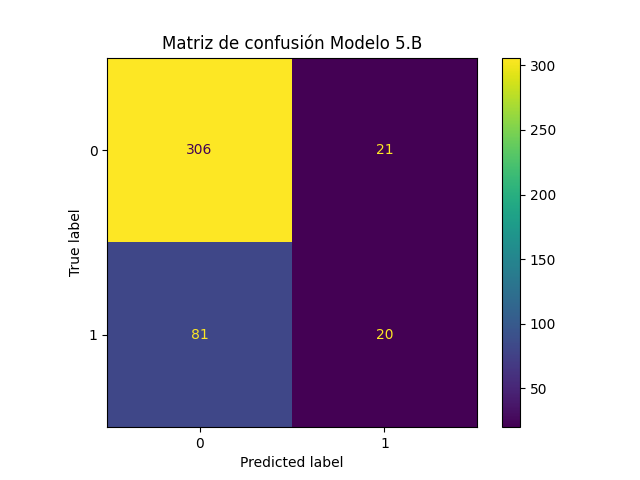

#### Comparación entre las Arquitecturas de Redes Neuronales
Al observar los resultados de los modelos de redes neuronales (Modelos 2 a 5.B), se puede notar una tendencia general en el rendimiento. En particular, los modelos más complejos, como el Modelo 5.B, alcanzan valores superiores de accuracy en comparación con modelos más simples como el Modelo 2 (una sola capa lineal). Sin embargo, el incremento en precisión no es proporcional a la complejidad añadida, ya que también existe una mayor sensibilidad al sobreajuste en los modelos más complejos. Este comportamiento es evidente en el Modelo 5.B, que incorpora múltiples capas y técnicas como dropout, pero no logra un incremento significativo en las métricas en comparación con modelos menos complejos. Esto sugiere que el conjunto de datos utilizado es relativamente pequeño para aprovechar completamente las capacidades de arquitecturas profundas, haciendo que modelos más simples sean más adecuados.

#### Análisis de la Matriz de Confusión
La matriz de confusión generada para el Modelo 5.B, que en el caso de los demás modelos es similar, refleja una clara asimetría en la clasificación de las dos clases. El modelo predice correctamente una gran mayoría de los casos de la clase 0 (307 aciertos frente a solo 20 errores), pero tiene dificultades para clasificar correctamente los casos de la clase 1, con 79 falsos negativos y solo 22 verdaderos positivos. Este patrón indica que el modelo está sesgado hacia la clase mayoritaria, lo que genera una alta precisión para la clase 0, sacrificando la sensibilidad para la clase 1.

Este comportamiento se observa en todos los modelos evaluados, lo que indica que el problema radica en el desbalance de clases presente en el conjunto de datos (75% clase 0 - 25% clase 1) más que en las arquitecturas específicas de las redes neuronales. Para abordar esta limitación, sería útil implementar técnicas de balanceo de clases, como ajustar los pesos en la función de pérdida o emplear métodos de sobremuestreo o submuestreo.

Sobre las métricas que se desprenden de la matriz (recall, precisión y F1), podemos ver como el modelo con mayor F1 es el modelo de regresión logística, siguiendole el modelo 3, luego el 5.B y por último el 4 y el 2. En todos los casos, la precisión y el recall igualmente indican valores bastante bajos. Esto entendemos que se debe a este desbalanceo de los datos que mencionamos anteriormente. Más allá de este desbalanceo, vemos como en general la regresión logística fue el modelo que mejor desempeñó en cuanto a precisión-recall y con un valor de accuracy bastante bueno en comparación con los demás modelos (76.64%).

#### Comparación entre Redes Neuronales y Algoritmos Clásicos
Para contrastar los resultados de las redes neuronales, también se incluyeron las tablas de los otros algoritmos, incluidos ID3 y Naive Bayes, con varias configuraciones. Los hallazgos principales incluyen:

ID3: Con valores de max_range_split de 2 y 3, ID3 logró un accuracy promedio de aproximadamente 83.31% en evaluación, superando a todos los modelos de redes neuronales. Este resultado sugiere que, para problemas con una estructura clara de decisión, los algoritmos basados en árboles pueden ofrecer una mayor efectividad al dividir el espacio de características de manera óptima.

Naive Bayes: Con diferentes valores de m, el rendimiento del Naive Bayes se mantuvo bastante estable, con un accuracy de entre 82.84% y 83.59% en evaluación. Aunque ligeramente inferior al ID3, el Naive Bayes muestra ser robusto y eficiente, especialmente en problemas donde las características son independientes o casi independientes.

Decision Tree y Random Forest: En comparación con las redes neuronales, los modelos de árboles de decisión como Decision Tree (gini) y Random Forest mostraron un rendimiento muy competitivo, logrando hasta un 89.20% de accuracy en evaluación con Random Forest. Esto resalta que, para el conjunto de datos actual, los métodos basados en árboles no solo ofrecen una precisión superior, sino también una mayor estabilidad en sus predicciones, como lo evidencia la baja desviación estándar en sus resultados.

Las redes neuronales, si bien ofrecen una flexibilidad significativa para capturar patrones complejos, muestran en este caso limitaciones debido a la naturaleza y tamaño del conjunto de datos. Los modelos más simples como el Modelo 3 ofrecen un rendimiento balanceado, mientras que el Modelo 5.B es excesivamente complejo y sensible al sobreajuste. En comparación, **algoritmos clásicos como ID3 y Random Forest** demuestran ser más efectivos y estables en este problema específico, indicando que las redes neuronales pueden no ser siempre la opción ideal para todos los conjuntos de datos, especialmente cuando estos son pequeños y lineales o poseen relaciones claras que pueden ser explotadas por métodos basados en árboles de decisión. 

## 4. Conclusión

En este laboratorio hemos podido implementar y experimentar con redes neuronales de distintos tamaños y arquitecturas. A su vez, hemos visto su comportamiento frente al modelo de regresión logística y a los modelos implementados en laboratorios anteriores.

Tras observar los resultados obtenidos pudimos sacar algunas conclusiones.

En primer lugar, vimos como los modelos de los laboratorios anteriores se comportan bastante mejor en cuanto a las métricas utilizadas que los modelos de redes neuronales. Incluso, el modelo de regresión logística también tiene un desempeño que se podría considerar levemente mejor. Esto creemos que se debe a la cantidad de instancias con las que cuenta el conjunto de datos para entrenamiento y luego validación. Las redes neuronales son un modelo que tiene resultados muy buenos cuando la cantidad de datos que se tiene para entrenar es alta. En este caso, con tan solo 2000 instancias en todo el conjunto de datos, no podemos esperar un rendimiento excelente ya que no es suficiente como para que la red encuentre todos los patrones significativos para la predicción. A su vez, vimos que cuanto más compleja es la red, hay más tendencia a sobreajuste si no se tienen los suficientes datos, por lo que en este caso modelos más simples de redes neuronales tuvieron mejores desempeños. 

A su vez, pudimos ver como el desbalanceo de clases hizo que los valores de precisión y recall de los modelos fueran relativamente bajos, haciendo que todos los modelos predijeran muy bien la clase 0 pero les costara más la predicción de la clase 1. 

En conclusión, este laboratorio nos permitió ahondar en el tema de las redes neuronales y su utilización para resolver problemas de clasificación, viendo sus ventajas y limitaciones, permitiendonos entender que no siempre un modelo es el mejor en todos los casos, y que depende bastante del conjunto de datos que se tenga a disposición y el tipo de problema que se quiera resolver.